In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1

from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker, diffHist
from ROOT import TFile, TH1, TH3F, TF2, TCanvas, TStyle, gStyle, Form, Fit
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime


Welcome to JupyROOT 6.28/04


In [2]:
current_GMT =   gmtime()
time_stamp = calendar.timegm(current_GMT)
DIR_NAME = f'results_{time_stamp}'
os.mkdir(DIR_NAME)

In [3]:
bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("088_090_ag123ag_2500A_accepted_np.dat", "_data", bins)
#histsData = histMakerData.makeHists()
histsData = histMakerData.makeHists()
#histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )
histMakerMC_rho = HistMaker("mar19_diele_inmedium_heli0cm_np.dat", "_MC", bins    )
histMakerMC_pi0 = HistMaker("mar19_diele_pi0_heli0cm_np.dat", "_MC", bins    )

iter 0
Before processing events 17:23:30
After processing events 17:23:33
iter 1
Before processing events 17:23:48
After processing events 17:23:49
iter 2
Before processing events 17:23:55
After processing events 17:23:55


Warning in <TROOT::Append>: Replacing existing TH1: hmass_MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz_MC (Potential memory leak).


Info in <TCanvas::Print>: gif file results_1695396159/base_hists_pi0_MC.gif has been created


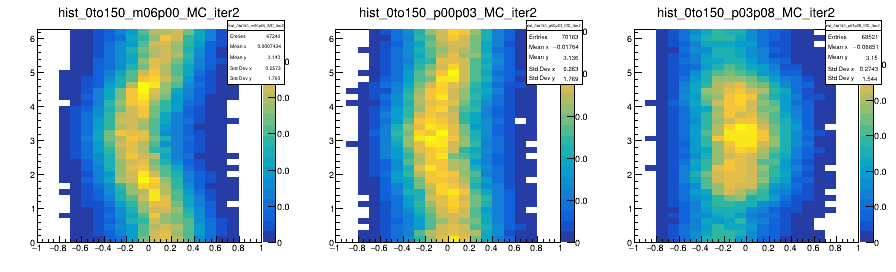

In [4]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.Draw("COLZ")
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")


ASImage2gif():1010:<results_1695396159/base_hists_rho_MC.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file results_1695396159/base_hists_rho_MC.gif


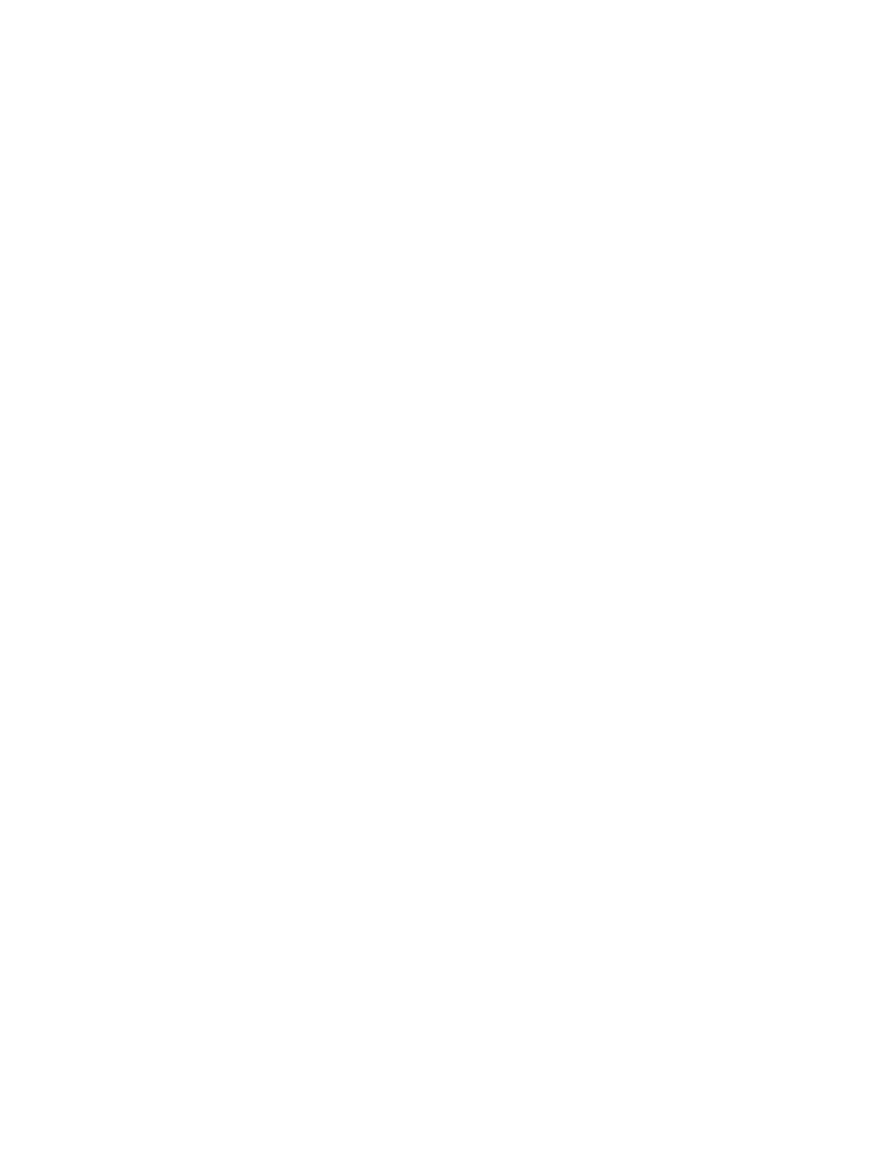

In [5]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can3.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


Info in <TCanvas::Print>: gif file results_1695396159/histsData.gif has been created


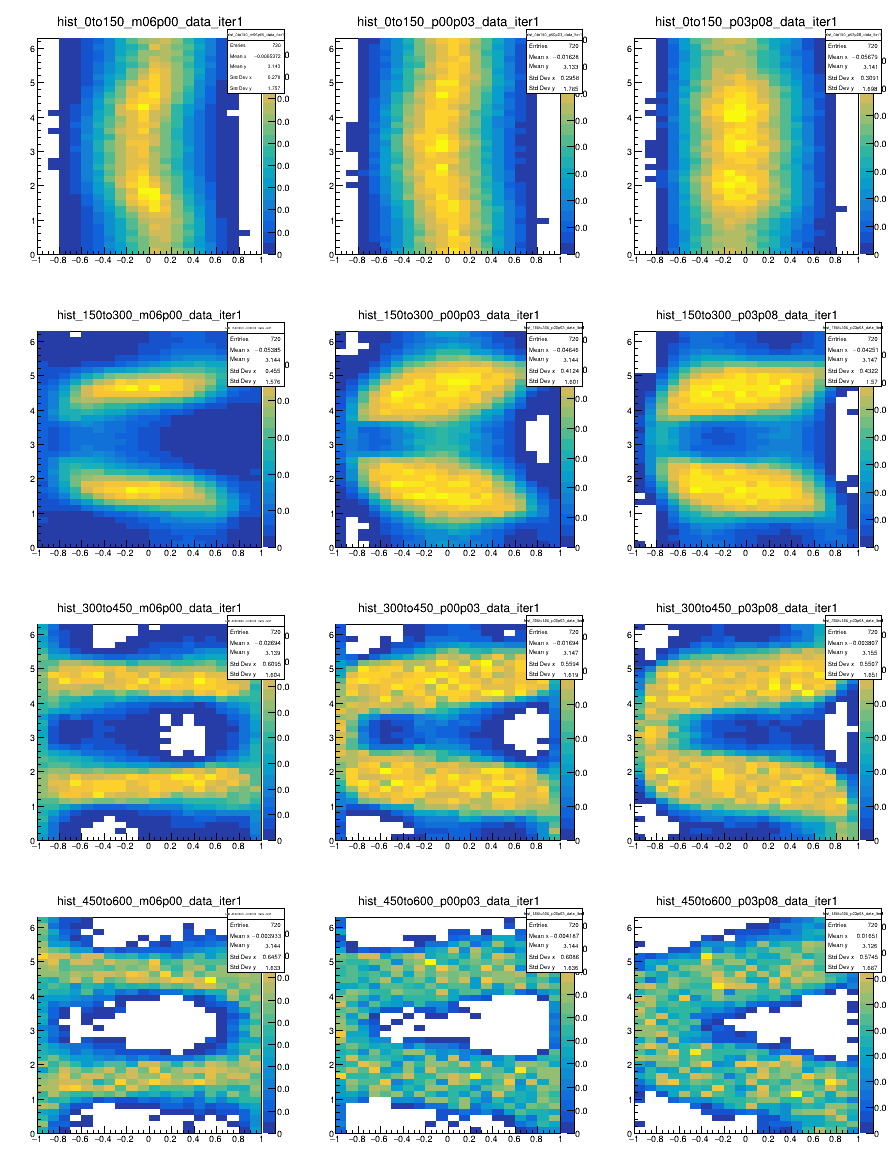

In [6]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData.gif')

In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 3

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[0, 0,         0],
                       [1, 2*math.pi, 2]], dtype=torch.float)
bounds = bounds.to(mps_device)


grid_r   = torch.linspace(bounds[0][0], bounds[1][0], 101)
grid_phi = torch.linspace(bounds[0][1], bounds[1][1], 101)
grid_z   = torch.linspace(bounds[0][2], bounds[1][2], 101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_r, grid_phi, grid_z, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-2

   # likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 150

In [12]:
def lambda_errors(xx, dxx):
    r, phi, z = xx[0], xx[1], xx[2]
    dr, dphi, dz = dxx[0], dxx[1], dxx[2]

    dlambda_theta_2 =     (dr * math.cos(phi)) ** 2 + (dphi * r * math.sin(phi)) ** 2 + (dz / 2) ** 2
    dlambda_phi_2   =     (dr * math.cos(phi) / 2) ** 2 + (dphi * r * math.sin(phi) / 2) ** 2 + (dz * 3 / 4) ** 2
    dlambda_theta_phi_2 = 0.5 * (dr * math.sin(phi)) ** 2 + 0.5 * (dphi * r * math.cos(phi)) ** 2

    dlambda_theta = math.sqrt(dlambda_theta_2)
    dlambda_phi = math.sqrt(dlambda_phi_2)
    dlambda_theta_phi = math.sqrt(dlambda_theta_phi_2)
    return dlambda_theta, dlambda_phi, dlambda_theta_phi

def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def all_lambdas(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)
            yield torch.tensor([lambda_theta, lambda_phi, lambda_theta_phi])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [13]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_titles = [r"R of cone coordinates", r"$\Phi$ of cone coordinates", r"Z of cone coordinates"]

def make_proj_2d(xs, tensor, transpose, index):
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))

        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
               xs_3d     = xs_3d    .transpose(transpose[0],transpose[1])
        return xs_3d, tensor_3d[index]

def make_proj_1d(xs, tensor, transpose1, transpose2, index1, index2):
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))

        if transpose1:
               tensor_3d = tensor_3d.transpose(transpose1[0],transpose1[1])
               xs_3d     = xs_3d    .transpose(transpose1[0],transpose1[1])
        if transpose2:
               tensor_3d = tensor_3d.transpose(transpose2[0],transpose2[1])
               xs_3d     = xs_3d    .transpose(transpose2[0],transpose2[1])
        return xs_3d, tensor_3d[index1][index2]

def oneplot(ax, tensor, index, cmap, title, transpose=None):
        
        global xs

        xs_3d, proj = make_proj_2d(xs, tensor, transpose, index)
        if transpose is None:
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        elif transpose == (0,1):
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][0],
                        xs_3d[0][-1][0][0],
                ]
        elif transpose == (0,2):
                extent=[
                        xs_3d[0][0][0][0],
                        xs_3d[0][0][-1][0],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        if transpose is None:
                x_title=axis_titles[2]
                y_title=axis_titles[1]
        elif transpose == (0, 1):
                x_title=axis_titles[2]
                y_title=axis_titles[0]
        elif transpose == (0,2):
                x_title=axis_titles[0]
                y_title=axis_titles[1]
        
        pos = ax.imshow(proj, cmap=cmap, interpolation="nearest", origin="lower", 
                vmin=0, vmax=tensor.max(), extent=extent)
        ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        plt.colorbar(pos,fraction=0.046, pad=0.04)



def bin_index(x, scale):
        return int(x*100/scale)

def ff(ax, x, transpose, scale):
        cmap = "gist_rainbow"
        index = bin_index(x, scale)
        oneplot(ax, predictive_mean, index, cmap, r"ndf$/\chi^2$", transpose)
       # oneplot(ax[1], predictive_upper-predictive_lower, index, cmap, "confidence int. width", transpose)
       # oneplot(ax[1], acquisition_score, index, cmap, "acquisition score", transpose)
        
        return ax


def f(ax, x):
        return ff(ax, x, None, 1.0)
        
def g(ax, x):
        return ff(ax, x, (0,1),2*math.pi)

def h(ax, x):
        return ff(ax, x, (0,2), 2.0)

gStyle.SetOptStat(0)

can_cmp_ind = 0

def plotComparison(histMC, histData):
    global can_cmp_ind

    can = TCanvas("can_cmp"+str(can_cmp_ind),"can",600,600)
    can_cmp_ind = can_cmp_ind+1
    can.Divide(2,2)
    can.Draw()
    can.cd(1)
    histMC.Draw("COLZ")
    can.cd(2)
    histData.Draw("COLZ")
    pad = can.cd(3)
    pad.SetRightMargin(0.155)
    pad = can.cd(3)
    hdiff = diffHist(histMC, histData)
    hdiff.Draw("COLZ")
    can.Update()
    palette = hdiff.GetListOfFunctions().FindObject("palette")
    palette.SetX1NDC(0.85)
    palette.SetX2NDC(0.9)
    can.Modified()
    can.Update()
    can.cd(4)
    nby = histMC.GetNbinsX()
    py = histMC.ProjectionY(histMC.GetName()+"py",1,nby)
    py.Draw("HIST")
    pyData = histData.ProjectionY("pyData",1,nby)
    pyData.SetLineColor(2)
    pyData.SetMarkerColor(2)
    pyData.Draw("SAME")
    return can, hdiff, py

In [14]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(HIST_INDEX = 0):
    global bounds

    histMakerMC = histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

                histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(3)
        while -2.0*result[0] - 1.0*result[2] < -2:
            result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(3)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    for trial in range(num_repeats):
        print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
            print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                    inequality_constraints=[(torch.tensor([0,2],device=mps_device),torch.tensor([-2.0,-1.0],dtype=torch.float,device=mps_device),-2.0)],
                )
            after_optimize_acqf = time()
            print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"./incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile("out_"+str(HIST_INDEX)+".root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_lower, predictive_upper = predictive_distribution.confidence_region()
        acquisition_score = policy(xs.unsqueeze(1))

    lds = all_lambdas(train_x)
    lambda_thetas     = lds.transpose(-2,-1)[0]
    lambda_phis       = lds.transpose(-2,-1)[1]
    lambda_theta_phis = lds.transpose(-2,-1)[2]
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        lambda_phis[0:num_queries],
        lambda_theta_phis[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, 4].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_mean

In [15]:

def convert_to_h3d(predictive_mean, HIST_INDEX):
    pm = predictive_mean.reshape(101,101,101)
    pm_min = pm.min()
    hpm = TH3F("hpm","predictive mean", 101, 0, 1, 101, 0, 2*math.pi, 101, 0, 2)
    for binx in range(1,101):
        for biny in range(1,101):
            for binz in range(1,101):
                if pm_min < 0:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item()-pm_min)
                else:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item())
    hpm.SaveAs(f"{DIR_NAME}/pm_{HIST_INDEX}.root")
    return hpm


In [16]:
def covariance_random_sampling(predictive_mean, HIST_INDEX):
    hpm = convert_to_h3d((predictive_mean, HIST_INDEX))

    from ctypes import c_double
    rnd_points = []

    x = c_double(0.0)
    y = c_double(0.0)
    z = c_double(0.0)
    for i in range(80_000_000):
        if i % 10000000 == 0:
            print(i)
        hpm.GetRandom3(x,y,z)
        rnd_points.append([x.value,y.value,z.value])

    print(x.value,y.value,z.value)
    covariance = np.cov(rnd_points, rowvar=False)
    return covariance

In [17]:
def covariance_weight(predictive_mean):
    predictive_mean_2 = predictive_mean - predictive_mean.min()

    covariance_2 = np.cov(xs, rowvar=False, aweights=predictive_mean_2)
    np.sqrt(covariance_2)

    return covariance_2

In [18]:
#cfit = TCanvas("cfit","cfit",500,500)
#cfit.Draw()
#cfit.cd()

def covariance_fit(hpm, best, HIST_INDEX):
    print(best)
    def gaus2d(X, a):
        N = a[0]
        m_x = a[1]
        m_y = a[2]

        K_xx = a[3]
        K_yy = a[4]

        K_xy = a[5]

        offset = a[6]

        x = X[0] - m_x
        y = X[1] - m_y

       # print(N, x, y, math.exp(-0.5*( x*x*K_xx + y*y*K_yy + 2*x*y*K_xy ) ) )
       
        return offset + N * math.exp( -0.5*(x*x*K_xx + y*y*K_yy + 2*x*y*K_xy) )

    def fit_2d(axis_ind):
        if axis_ind == 0:
            axis = hpm.GetXaxis()
            proj_option = "yz"
            proj_X_ind, proj_Y_ind = 2, 1
        elif axis_ind == 1:
            axis = hpm.GetYaxis()
            proj_option = "zx"
            proj_X_ind, proj_Y_ind = 0, 2
        else:
            axis = hpm.GetZaxis()
            proj_option = "xy"
            proj_X_ind, proj_Y_ind = 1, 0
        bin = axis.FindBin(best[axis_ind])
        axis.SetRange(bin, bin)
        
        proj = hpm.Project3D(proj_option)

        proj_lastbin_X = proj.GetXaxis().GetNbins()
        proj_max_X = proj.GetXaxis().GetBinUpEdge(proj_lastbin_X)
        proj_lastbin_Y = proj.GetYaxis().GetNbins()
        proj_max_Y = proj.GetYaxis().GetBinUpEdge(proj_lastbin_Y)
        scale_X = 0.2*proj_max_X
        scale_Y = 0.2*proj_max_Y

        xmin = min( best[proj_X_ind]-scale_X, 0.0)
        xmax = min( best[proj_X_ind]+scale_X, proj_max_X)
        ymin = min( best[proj_Y_ind]-scale_Y, 0.0)
        ymax = min( best[proj_Y_ind]+scale_Y, proj_max_Y)

        f2 = TF2("f2", gaus2d, xmin, xmax, ymin, ymax, 6)
        f2.SetParameter(0,1)
        f2.FixParameter(1,best[proj_X_ind])
        f2.FixParameter(2,best[proj_Y_ind])
        f2.SetParameter(3,0.2*best[proj_X_ind])
        f2.SetParameter(4,0.2*best[proj_Y_ind])
        f2.SetParameter(5,0)
        f2.SetParameter(6,0)

        print("type of proj", type(proj))
        print("type of f2", type(f2))
        proj.Fit(f2,"R0")
    
        return f2.GetParameter(3), f2.GetParameter(4), f2.GetParameter(5)

    params0 = fit_2d(0)
    params1 = fit_2d(1)
    params2 = fit_2d(2)

    params = np.array([params0,params1,params2])
    print(params)


In [19]:
def covariance_fit_scipy(predictive_mean, best, HIST_INDEX,ax):
   # def gaus1d(x, A, mean_x, sigma_x, offset):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
       # z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

   # def gaus2d(X, A, mean_x, mean_y, K_xx, K_yy, K_xy, offset):
    def gaus2d(X, A, mean_x, mean_y, K_xx, K_yy, K_xy, offset):
        (x, y) = X
        x = x - mean_x
        y = y - mean_y
       # print("HERE 1: ", A, K_xx, x, K_yy, y, K_xy)
       # print("HERE 2: ", K_xx * x **2, K_yy * y **2, K_xy * x * y)
       # print("HERE 3: ", offset + np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) ))
        z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) )
       # print("z SHAPE: ", z.shape)
       # print("z.ravel() SHAPE: ", z.ravel().shape)
       # return z.ravel()
        return z

    def gaus3d(X, A, mean_x, mean_y, mean_z, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset):
        (x, y, z) = X
        x = x - mean_x
        y = y - mean_y
        z = z - mean_z
        z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + K_zz * z ** 2 + 
            2 * K_xy * x * y + 2 * K_yz * y * z + 2 * K_zx * z * x) )
        return z

    def gaus2d_fixed_mean(mean_x, mean_y):
        def inner(X, A, K_xx, K_yy, K_xy, offset):
            (x, y) = X
            x = x - mean_x
            y = y - mean_y
            z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) )
            return z
        return inner

    def gaus3d_fixed_mean(mean_x, mean_y, mean_z):
        def inner(X, A, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset):
            (x, y, z) = X
            x = x - mean_x
            y = y - mean_y
            z = z - mean_z
            z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + K_zz * z ** 2 + 
                2 * K_xy * x * y + 2 * K_yz * y * z + 2 * K_zx * z * x) )
            return z
        return inner

    def fit_1d(axis_ind, ax):
        if axis_ind == 0:
            axis1, axis2 = 1, 2
            trasnpose1, transpose2 = (0, 1), (1, 2)
        elif axis_ind == 1:
            axis1, axis2 = 2, 0
            trasnpose1, transpose2 = (0, 1), (0, 2)
        else:
            axis1, axis2 = 0, 1
            trasnpose1, transpose2 = None, None

        mean_x = best[axis_ind].item()

        scale1 = bounds[1][axis1].item()
        scale2 = bounds[1][axis2].item()
        proj_max_X = bounds[1][axis_ind].item()

        index1 = bin_index(train_x_sorted[-1][axis1], scale1)
        index2 = bin_index(train_x_sorted[-1][axis2], scale2)
        _, proj = make_proj_1d(xs, predictive_mean, trasnpose1, transpose2, index1, index2)

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X

        x = np.linspace(0, proj_max_X, 101)
       # fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False)
        ax.plot(x, proj, label="Estimated values")
        ax.set_xlabel(axis_titles[axis_ind])
        ax.set_ylabel(r"ndf$/\chi^2$")
        proj1 = proj[xmin_ind:xmax_ind]
    
       # initial_guess = (1.0, mean_x, 0.2*proj_max_X, 0.0)
        initial_guess = (1.0, mean_x, 0.2*proj_max_X)

        popt, pcov = opt.curve_fit(gaus1d, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess)
        fit_result = gaus1d(x, *(popt))
        ax.plot(x, fit_result, label="Gaussian fit")
        ax.set_xlabel(axis_titles[axis_ind])
        ax.set_ylabel(r"ndf$/\chi^2$")
        ax.set_ylim([0,predictive_mean.max()])
        ax.legend()
        return popt, pcov


    def fit_2d(axis_ind):
        if axis_ind == 0:
            trasnpose = None
            proj_X_ind, proj_Y_ind = 2, 1
        elif axis_ind == 1:
            trasnpose = (0, 1)
            proj_X_ind, proj_Y_ind = 0, 2
        else:
            trasnpose = (0, 2)
            proj_X_ind, proj_Y_ind = 0, 1

        mean_x = best[proj_X_ind].item()
        mean_y = best[proj_Y_ind].item()

        scale = bounds[1][axis_ind].item()
        proj_max_X = bounds[1][proj_X_ind].item()
        proj_max_Y = bounds[1][proj_Y_ind].item()

        index = bin_index(train_x_sorted[-1][axis_ind], scale)
        _, proj = make_proj_2d(xs, predictive_mean, trasnpose, index)

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        ymin_ind = max(0,   bin_index(mean_y, proj_max_Y)-30)
        ymax_ind = min(100, bin_index(mean_y, proj_max_Y)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X
        ymin = ymin_ind / 100. * proj_max_Y
        ymax = (ymax_ind + 1) / 100. * proj_max_Y

        fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, constrained_layout=True)
        ax[0].imshow(proj, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=proj_max_X/proj_max_Y,
            vmin=0, vmax=predictive_mean.max(), extent=(0,proj_max_X,0,proj_max_Y))
        proj1 = proj[ymin_ind:ymax_ind, xmin_ind:xmax_ind]

       # initial_guess = (1.0, mean_x, mean_y, 0.2*proj_max_X, 0.2*proj_max_Y, 0.0, 0.0)
        initial_guess = (1.0, 0.2*proj_max_X, 0.2*proj_max_Y, 0.0, 0.0)
    
        x = np.linspace(xmin, xmax, xmax_ind-xmin_ind)
        y = np.linspace(ymin, ymax, ymax_ind-ymin_ind)
        x, y = np.meshgrid(x, y)
        x = x.flatten()
        y = y.flatten()

        ax[1].imshow(proj1, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=(xmax-xmin)/(ymax-ymin),
            vmin=0, vmax=predictive_mean.max(), extent=(xmin,xmax,ymin,ymax))
        popt, pcov = opt.curve_fit(gaus2d_fixed_mean(mean_x, mean_y), (x,y), proj1.ravel(), p0 = initial_guess)
        fit_result = gaus2d_fixed_mean(mean_x, mean_y)((x,y), *(popt)).reshape(ymax_ind-ymin_ind,xmax_ind-xmin_ind)
        ax[2].imshow(fit_result, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=(xmax-xmin)/(ymax-ymin),
            vmin=0, vmax=predictive_mean.max(), extent=(xmin,xmax,ymin,ymax))
        return popt, pcov

    def fit_3d():
        mean_x = best[0].item()
        mean_y = best[1].item()
        mean_z = best[2].item()
        
        proj_max_X = bounds[1][0].item()
        proj_max_Y = bounds[1][1].item()
        proj_max_Z = bounds[1][2].item()

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        ymin_ind = max(0,   bin_index(mean_y, proj_max_Y)-30)
        ymax_ind = min(100, bin_index(mean_y, proj_max_Y)+30)
        zmin_ind = max(0,   bin_index(mean_z, proj_max_Z)-30)
        zmax_ind = min(100, bin_index(mean_z, proj_max_Z)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X
        ymin = ymin_ind / 100. * proj_max_Y
        ymax = (ymax_ind + 1) / 100. * proj_max_Y
        zmin = zmin_ind / 100. * proj_max_Z
        zmax = (zmax_ind + 1) / 100. * proj_max_Z

        predictive_mean1 = predictive_mean.reshape(101,101,101)
        predictive_mean1 = predictive_mean1[xmin_ind:xmax_ind,ymin_ind:ymax_ind,zmin_ind:zmax_ind]

       # initial_guess = (1.0, mean_x, mean_y, mean_z, 0.2*proj_max_X, 0.2*proj_max_Y, 0.2*proj_max_Z, 0.0, 0.0, 0.0, 0.0)
        initial_guess = (1.0, 0.2*proj_max_X, 0.2*proj_max_Y, 0.2*proj_max_Z, 0.0, 0.0, 0.0, 0.0)
    
        x = np.linspace(xmin, xmax, xmax_ind-xmin_ind)
        y = np.linspace(ymin, ymax, ymax_ind-ymin_ind)
        z = np.linspace(zmin, zmax, zmax_ind-zmin_ind)
        x, y, z = np.meshgrid(x, y, z)
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()

        popt, pcov = opt.curve_fit(gaus3d_fixed_mean(mean_x, mean_y, mean_z), (x,y,z), predictive_mean1.ravel(), p0 = initial_guess)
        return popt, pcov

   # fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, constrained_layout=True)
    params0, _ = fit_1d(0, ax[1][0])
   # print("params0: ", params0)
    params1, _ = fit_1d(1, ax[1][1])
   # print("params1: ", params1)
    params2, _ = fit_1d(2, ax[1][2])
   # print("params2: ", params2)

    return params0[2], params1[2], params2[2]


### A, mean_x, mean_y, mean_z, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset
   # params, _ = fit_3d()

   # print("PARAMS: ", params)
   # PARAM_OFFSET=-3

   # K_RR = params[4+PARAM_OFFSET]
   # K_PhiPhi = params[5+PARAM_OFFSET]
   # K_ZZ = params[6+PARAM_OFFSET]    
   # K_ZPhi = params[7+PARAM_OFFSET]
   # K_ZR = params[8+PARAM_OFFSET]
   # K_RPhi = params[9+PARAM_OFFSET]

   # K = np.array([
   #     [K_RR,   K_RPhi,   K_ZR],
   #     [K_RPhi, K_PhiPhi, K_ZPhi],
   #     [K_ZR,   K_ZPhi,   K_ZZ]
   # ])

   # print("K 1: ", K)
   # Sigma = np.linalg.inv(K)
   # print("COVARIANCE 1: ", Sigma)

   # PARAM_OFFSET=-2
   
   # params0, _ = fit_2d(0)
   # print("params0: ", params0[3+PARAM_OFFSET:6+PARAM_OFFSET])
   # params1, _ = fit_2d(1)
   # print("params1: ", params1[3+PARAM_OFFSET:6+PARAM_OFFSET])
   # params2, _ = fit_2d(2)
   # print("params2: ", params2[3+PARAM_OFFSET:6+PARAM_OFFSET])

   # K_RR_a, K_RR_b = params2[3+PARAM_OFFSET], params1[4+PARAM_OFFSET]
   # K_PhiPhi_a, K_PhiPhi_b = params0[4+PARAM_OFFSET], params2[4+PARAM_OFFSET]
   # K_ZZ_a, K_ZZ_b = params0[3+PARAM_OFFSET], params1[3+PARAM_OFFSET]
   # K_RR = 0.5*(K_RR_a + K_RR_b)
   # K_PhiPhi = 0.5*(K_PhiPhi_a + K_PhiPhi_b)
   # K_ZZ = 0.5*(K_ZZ_a + K_ZZ_b)
   # K_ZPhi = params0[5+PARAM_OFFSET]
   # K_ZR = params1[5+PARAM_OFFSET]
   # K_RPhi = params2[5+PARAM_OFFSET]

   # K = np.array([
   #     [K_RR,   K_RPhi,   K_ZR],
   #     [K_RPhi, K_PhiPhi, K_ZPhi],
   #     [K_ZR,   K_ZPhi,   K_ZZ]
   # ])
   # print("K 2: ", K)
   # Sigma = np.linalg.inv(K)
   # print("COVARIANCE 2: ", Sigma)

In [20]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []

range_used = range(2)

for HIST_INDEX in range_used:
    allHistsMC = []

    c_sorted, train_x_sorted, predictive_mean = fit_bo(HIST_INDEX)
    print(c_sorted[-5:])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)


trial 0


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 1.6423909664154053 seconds
Optimizing ACQF took 1.6684191226959229 seconds
Fitting GP took 1.674971103668213 seconds
Optimizing ACQF took 1.9867451190948486 seconds
Fitting GP took 1.8628151416778564 seconds
Optimizing ACQF took 2.04534912109375 seconds
Fitting GP took 1.6227059364318848 seconds
Optimizing ACQF took 0.5855858325958252 seconds
Fitting GP took 1.8072218894958496 seconds
Optimizing ACQF took 2.3194780349731445 seconds
Fitting GP took 1.6640651226043701 seconds
Optimizing ACQF took 1.6975979804992676 seconds
Fitting GP took 1.5950977802276611 seconds
Optimizing ACQF took 2.600079298019409 seconds
Fitting GP took 1.8013319969177246 seconds
Optimizing ACQF took 2.565851926803589 seconds
Fitting GP took 3.12717604637146 seconds
Optimizing ACQF took 3.790714979171753 seconds
Fitting GP took 4.455716848373413 seconds
Optimizing ACQF took 3.8071720600128174 seconds
Fitting GP took 4.584099054336548 seconds
Optimizing ACQF took 3.971917152404785 seconds
Fitting GP

  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 1.6168668270111084 seconds
Optimizing ACQF took 1.9971699714660645 seconds
Fitting GP took 1.8126461505889893 seconds
Optimizing ACQF took 2.084104299545288 seconds
Fitting GP took 1.7142620086669922 seconds
Optimizing ACQF took 2.206583023071289 seconds
Fitting GP took 1.6156799793243408 seconds
Optimizing ACQF took 2.1461551189422607 seconds
Fitting GP took 1.7699089050292969 seconds
Optimizing ACQF took 2.206789970397949 seconds
Fitting GP took 1.6016669273376465 seconds
Optimizing ACQF took 2.326347827911377 seconds
Fitting GP took 1.7220799922943115 seconds
Optimizing ACQF took 2.083091974258423 seconds
Fitting GP took 1.7927348613739014 seconds
Optimizing ACQF took 2.442294120788574 seconds
Fitting GP took 2.0109050273895264 seconds
Optimizing ACQF took 1.862029790878296 seconds
Fitting GP took 1.7019720077514648 seconds
Optimizing ACQF took 1.892293930053711 seconds
Fitting GP took 1.740997076034546 seconds
Optimizing ACQF took 1.6981709003448486 seconds
Fitting 

Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing exist

0: Final result:
0: lambdas =  tensor([ 0.7420,  0.0021, -0.3348])
0: errors =  (0.5394808762778548, 0.4033281265499378, 0.31233029525959305)
1: Final result:
1: lambdas =  tensor([ 0.9466, -0.0172, -0.1585])
1: errors =  (0.5040665305083508, 0.3647802865420804, 0.47843505803935776)


Info in <TCanvas::Print>: gif file results_1695396159/comparison_bestIndex_0.gif has been created
Info in <TCanvas::Print>: gif file results_1695396159/comparison_worstIndex_0.gif has been created
Info in <TCanvas::Print>: gif file results_1695396159/comparison_bestIndex_1.gif has been created
Info in <TCanvas::Print>: gif file results_1695396159/comparison_worstIndex_1.gif has been created


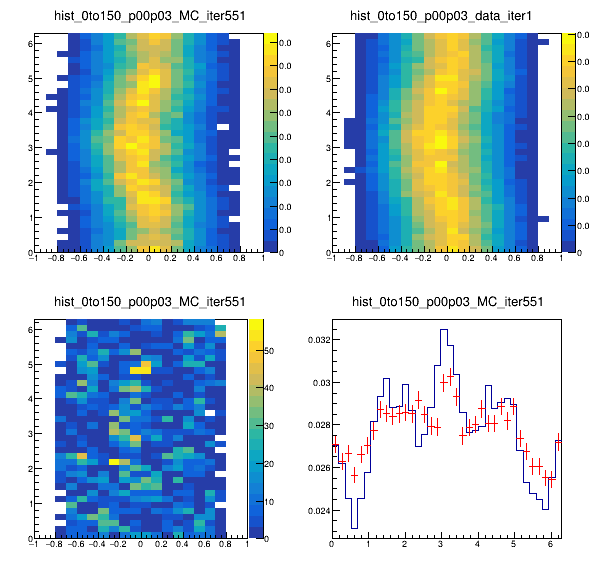

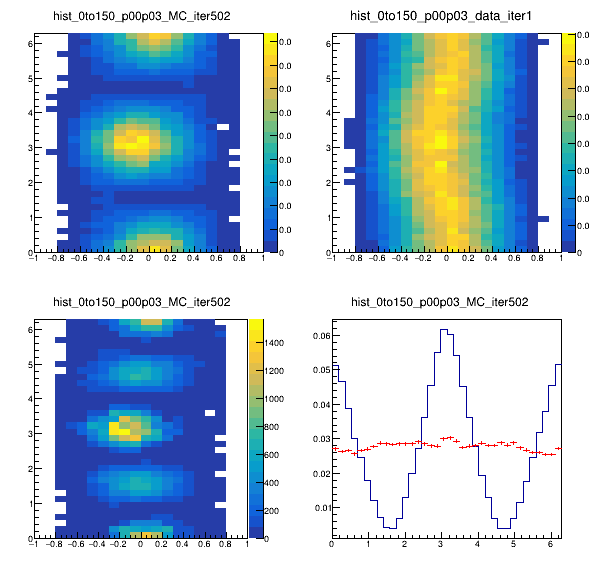

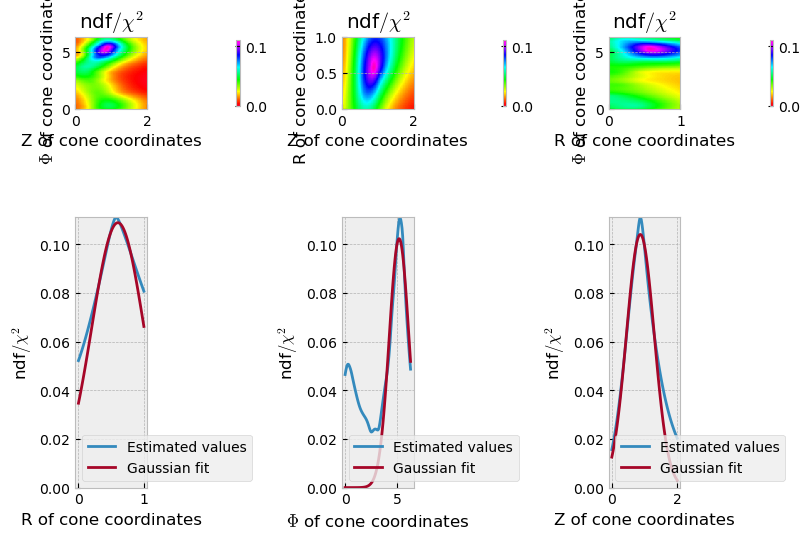

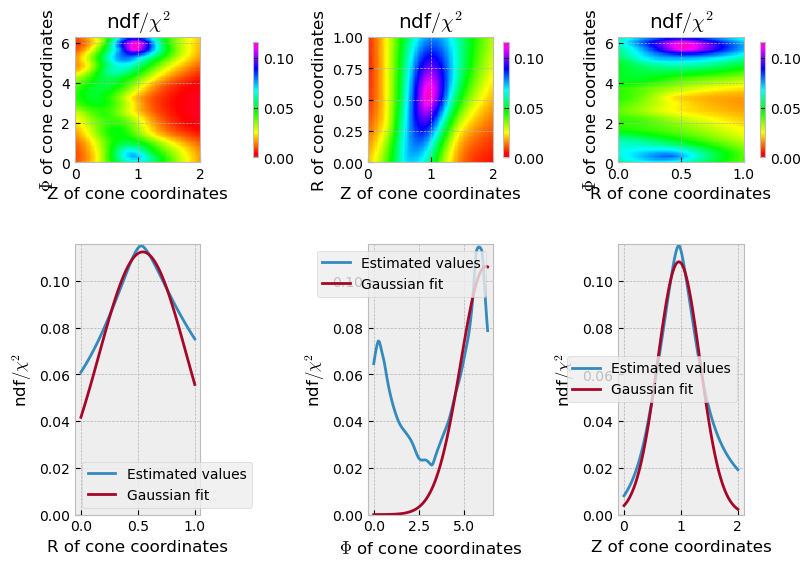

In [21]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX]
        train_x_sorted = train_x_sorted_all[HIST_INDEX]
        predictive_mean = predictive_mean_all[HIST_INDEX]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

        fig, ax = plt.subplots(nrows=2, ncols=3, sharey=False, constrained_layout=True)
       # convert_to_h3d(predictive_mean, HIST_INDEX)
        #interact(f, x=FloatSlider(description=axis_titles[0], min=0.0, max=1.0, step=0.01, value=train_x_sorted[-1][0], layout=Layout(width='500px')))
        f(ax[0][0], train_x_sorted[-1][0])
       # plt.savefig("chi2_bestR_" + str(HIST_INDEX) + ".png")
        #interact(g, x=FloatSlider(description=axis_titles[1], min=0.0, max=2*math.pi, step=0.01, value=train_x_sorted[-1][1], layout=Layout(width='500px')))
        g(ax[0][1], train_x_sorted[-1][1])
       # plt.savefig("chi2_bestPhi_" + str(HIST_INDEX) + ".png")
        #interact(h, x=FloatSlider(description=axis_titles[2], min=0.0, max=2, step=0.01, value=train_x_sorted[-1][2], layout=Layout(width='500px')))
        h(ax[0][2], train_x_sorted[-1][2])
       # plt.savefig("chi2_bestZ_" + str(HIST_INDEX) + ".png")

        bestIndex = int(c_sorted[-1][0].item())
        can1, hdiff1, py1 = plotComparison(allHistsMC[bestIndex], histsData[0][HIST_INDEX])
        can1.SaveAs(f"{DIR_NAME}/comparison_bestIndex_{HIST_INDEX}.gif")

        worstIndex = int(c_sorted[0][0].item())
        can2, hdiff2, py2 = plotComparison(allHistsMC[worstIndex], histsData[0][HIST_INDEX])
        can2.SaveAs(f"{DIR_NAME}/comparison_worstIndex_{HIST_INDEX}.gif")

        all = all_lambdas(xs)
        cov_lambda = np.cov(all, rowvar=False, aweights=predictive_mean_2)
        sgn_lambda = 1.0*(cov_lambda > 0) + -1.0*(cov_lambda < 0)

        np.multiply(
            sgn_lambda, np.sqrt(
                np.multiply(
                    sgn_lambda, cov_lambda
                )
            )
        )
        print(str(HIST_INDEX) + ": Final result:")
        print(str(HIST_INDEX) + ": Final result:", file=fout)
        print(str(HIST_INDEX) + ": lambdas = ", c_sorted[-1][1:4])
        print(str(HIST_INDEX) + ": lambdas = ", c_sorted[-1][1:4], file=fout)
   # print(str(HIST_INDEX) + ": covariance matrix: \n", cov_lambda)

   # hpm = convert_to_h3d(predictive_mean, HIST_INDEX)
   # covariance_fit(hpm,train_x_sorted[-1],HIST_INDEX)
        drphiz = covariance_fit_scipy(predictive_mean,train_x_sorted[-1],HIST_INDEX,ax)

        print(str(HIST_INDEX) + ": errors = ", lambda_errors(train_x_sorted[-1], drphiz))
        print(str(HIST_INDEX) + ": errors = ", lambda_errors(train_x_sorted[-1], drphiz), file=fout)
    
#allHistsMC = []
#for ind in range(1):
#    task(ind)

#with multiprocessing.Pool() as pool:
#    pool.map(task, range(3))